# Feed-forward training

## Imports

In [1]:
import sys
sys.path.append('../')

import thermonets as tn
import torch
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Loading input data

In [2]:
#Loads the data generated via `/scripts/generate_nrlmsise00_db.py` and print the columns
#note that columns can be (len 16):
#'day', 'month', 'year', 'hour', 'minute', 'second', 'microsecond', 'alt [km]', 'lat [deg]', 'lon [deg]', 'f107A', 'f107', 'ap', 'wind zonal [m/s]', 'wind meridional [m/s]', 'density [kg/m^3]'
#or (len 14):
#'day', 'month', 'year', 'hour', 'minute', 'second', 'microsecond', 'alt [km]', 'lat [deg]', 'lon [deg]', 'f107A', 'f107', 'ap', 'density [kg/m^3]'
db=np.loadtxt('../dbs/nrlmsise00_db.txt',delimiter=',',skiprows=1)
print(f'Shape of database is: {db.shape}')

Shape of database is: (999700, 14)


## Extracting features of interest

In [3]:
# Renames some of the db content with readable names
days=db[:,0]
months=db[:,1]
years=db[:,2]
hours=db[:,3]
minutes=db[:,4]
seconds=db[:,5]
microseconds=db[:,6]
alt=db[:,7]
# Geodetic longitude and latitude are converted in radians:
lat=np.deg2rad(db[:,8])
lon=np.deg2rad(db[:,9])
# Space weather indices:
f107a=db[:,10]
f107=db[:,11]
ap=db[:,12]
# Atmospheric density as well:
target_density=db[:,-1]

# We need to extract from the db also the doy (Day of Year) and the sid (seconds in day)
seconds_in_day=hours*3600+minutes*60+seconds+microseconds/1e6
print('seconds in day min and max:')
print(seconds_in_day.min(), seconds_in_day.max())
doys=np.zeros(db.shape[0])
for i in range(len(db)):
    #date is a string, so I first convert it to datetime:
    date_=datetime.datetime(year=int(years[i]), 
                            month=int(months[i]), 
                            day=int(days[i]),
                            hour=int(hours[i]),
                            minute=int(minutes[i]),
                            second=int(seconds[i]),
                            microsecond=int(microseconds[i]))
    doys[i]=date_.timetuple().tm_yday
print('day of the year min and max:')
print(doys.min(), doys.max())

seconds in day min and max:
20.64977 86392.51835
day of the year min and max:
1.0 365.0


## Normalization

In [4]:
db_processed=np.zeros((db.shape[0],13))
db_processed[:,0]=np.sin(lon)
db_processed[:,1]=np.cos(lon)
db_processed[:,2]=np.sin(lat)
db_processed[:,3]=np.sin(2*np.pi*seconds_in_day/86400.)
db_processed[:,4]=np.cos(2*np.pi*seconds_in_day/86400.)
db_processed[:,5]=np.sin(2*np.pi*doys/365.25)
db_processed[:,6]=np.cos(2*np.pi*doys/365.25)
db_processed[:,7]=tn.normalize_min_max(f107, 60., 266.)
db_processed[:,8]=tn.normalize_min_max(f107a, 60., 266.)
db_processed[:,9]=tn.normalize_min_max(ap, 0., 110.)
db_processed[:,10]=tn.normalize_min_max(alt, 170., 1010.)

#Add the non-normalized density & altitude columns (useful to extract during training):
db_processed[:,11]= alt
db_processed[:,12]= target_density

# Cross check that the max is <=1 and the min is >=-1
print(f"maximum and minimum of all the normalized data: {db_processed[:,7:11].max()}, {db_processed[:,7:11].min()}")
print(f"maximum and minimum of target density: {target_density.max()}, {target_density.min()}")

maximum and minimum of all the normalized data: 0.9761904761904763, -1.0
maximum and minimum of target density: 7.20569529348575e-10, 1.9693989513886182e-16


## NN Training

In [5]:
torch_data = torch.tensor(db_processed, dtype=torch.float32)

In [6]:
# NN hyperparameters
device = torch.device('cpu')
minibatch_size = 4096
model_path = None #pass a path to a model in case you want to continue training from a file
lr = 0.001
epochs = 100

In [15]:
#NN creation
model = tn.ffnn(input_dim=db_processed.shape[1]-3,
                        hidden_layer_dims=[32, 32],
                        output_dim=12,
                        mid_activation=torch.nn.Tanh(),
                        last_activation=torch.nn.Tanh()).to(device)

if model_path is not None:
    model.load_state_dict(torch.load(model_path,
                                     map_location=device.type))

In [16]:
# Here we set the optimizer
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 1000, min_lr = 1e-7, verbose=False)
#criterion = tn.MAPE()
criterion = tn.MSE_LOG10()

# And the dataloader
dataloader = torch.utils.data.DataLoader(torch_data, 
                                         batch_size=minibatch_size, 
                                         shuffle=True)


In [17]:
print(f'Total number of model parameters: {sum(p.numel() for p in model.parameters())}')

Total number of model parameters: 1804


We load the global fit (see notebook: `rho_global_fit.ipynb`: this will be the baseline from which we ask the NN to learn corrections)

In [18]:
with open('../global_fits/global_fit_nrlmsise00_180.0-1000.0-4.txt','rb') as f:
    best_global_fit=torch.from_numpy(pickle.load(f)).to(device)

In [19]:
# Training loop
ratio_losses=[]
mse_per_minibatch_nn=[]
mape_per_minibatch_nn=[]
mse_per_minibatch_fit=[]
mape_per_minibatch_fit=[]
for epoch in range(epochs):
    total_mse = 0.0
    total_mape = 0.0
    for batch_idx,el in enumerate(dataloader):
        minibatch=el[:,:-3].to(device)
        altitude=el[:,-2].to(device)
        rho_target=el[:,-1].to(device)
        delta_params = model(minibatch).to(device)

        #Constructs the inputs for the compute_approximated_density function as corrections from the global fit:
        params = best_global_fit*(1+delta_params)
        rho_nn=tn.rho_approximation(h=altitude,
                                                params=params,
                                                backend='torch')
        rho_fit=tn.rho_approximation(h=altitude,
                                             params=best_global_fit,
                                             backend='torch')

        loss = criterion(rho_nn, rho_target)

        #Computes the global fit loss:
        loss_fit =  criterion(rho_fit, rho_target)

        # Zeroes the gradient (necessary because of things)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
        # Perform a step in LR scheduler to update LR
        scheduler.step(loss.item())

        #We compute the logged quantities
        mse_per_minibatch_nn.append(loss.item())
        mape_per_minibatch_nn.append(tn.mean_absolute_percentage_error(rho_nn, rho_target).item())
        total_mse+=mse_per_minibatch_nn[-1]
        total_mape+=mape_per_minibatch_nn[-1]
        
        #Now the same but for the global fit:
        mse_per_minibatch_fit.append(loss_fit.item())
        mape_per_minibatch_fit.append(tn.mean_absolute_percentage_error(rho_fit, rho_target).item())

        #Ratio of the loss between the NN and the fit (the lower, the more the NN is doing better than a global fit)
        ratio_losses.append(loss.item()/loss_fit.item())
        #Save the best model (this is wrong and should be done on the dataset):
        if batch_idx>1:
            if mse_per_minibatch_nn[-1]<min(mse_per_minibatch_nn[:-1]):    
                #updating torch best model:
                torch.save(model.state_dict(), f'../models/nrlmsise00_model_xxx.pyt')
                best_loss=loss.item()
                #print(f'Saving model - current best loss: {best_loss}\n')
        else:
            best_loss=loss.item()
        #Print every 10 minibatches:
        if batch_idx%10:    
            print(f'minibatch: {batch_idx}/{len(dataloader)}, ratio: {ratio_losses[-1]:.4e}, best loss till now: {best_loss:.4e}, loss RMSE (log10) & MAPE -----  NN: {loss.item():.10f}, {mape_per_minibatch_nn[-1]:.7f}; fit: {loss_fit.item():.10f}, {mape_per_minibatch_fit[-1]:.7f}', end='\r')
    #Print at the end of the epoch
    curr_lr = scheduler.optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch + 1}/{epochs}, lr: {curr_lr:.1e}, average MSE (log10) loss: {total_mse / len(dataloader)}, average MAPE: {total_mape / len(dataloader)}                                                                                                                                                             ')


Epoch 1/100, lr: 1.0e-03, average MSE (log10) loss: 0.03530084914622866, average MAPE: 34.315635307467716                                                                                                                                                             
Epoch 2/100, lr: 1.0e-03, average MSE (log10) loss: 0.009809552684274254, average MAPE: 16.881024461862992                                                                                                                                                             
Epoch 3/100, lr: 1.0e-03, average MSE (log10) loss: 0.00598497655128642, average MAPE: 13.301208204152633                                                                                                                                                             
Epoch 4/100, lr: 1.0e-03, average MSE (log10) loss: 0.005012859789920705, average MAPE: 12.159194681595784                                                                                                        

In [55]:
delta_params = model(torch_data[:,:-3]).to(device)
params = best_global_fit*(1+delta_params)
rho_nn=tn.rho_approximation(h=torch_data[:,-2],params=params,backend='torch')
rho_fit=tn.rho_approximation(h=torch_data[:,-2],params=best_global_fit,backend='torch')


(array([7.64500e+03, 2.64130e+04, 4.06470e+04, 4.90810e+04, 5.72110e+04,
        7.10660e+04, 9.92010e+04, 1.13134e+05, 1.03492e+05, 8.40460e+04,
        6.50050e+04, 4.75570e+04, 3.65600e+04, 2.81690e+04, 2.27910e+04,
        1.85690e+04, 1.53900e+04, 1.29820e+04, 1.11430e+04, 9.65900e+03,
        8.51100e+03, 7.53300e+03, 6.59300e+03, 5.89700e+03, 5.42100e+03,
        4.88700e+03, 4.48700e+03, 4.00200e+03, 3.50700e+03, 3.02000e+03,
        2.87500e+03, 2.59500e+03, 2.19800e+03, 1.99900e+03, 1.73000e+03,
        1.54300e+03, 1.40000e+03, 1.22100e+03, 1.07700e+03, 9.33000e+02,
        8.67000e+02, 7.99000e+02, 7.22000e+02, 6.26000e+02, 5.09000e+02,
        4.84000e+02, 4.68000e+02, 4.05000e+02, 3.59000e+02, 3.49000e+02,
        2.93000e+02, 2.94000e+02, 2.83000e+02, 2.28000e+02, 2.00000e+02,
        1.67000e+02, 1.66000e+02, 1.41000e+02, 1.45000e+02, 1.29000e+02,
        1.14000e+02, 9.50000e+01, 8.10000e+01, 7.80000e+01, 7.30000e+01,
        6.00000e+01, 5.90000e+01, 7.40000e+01, 4.90

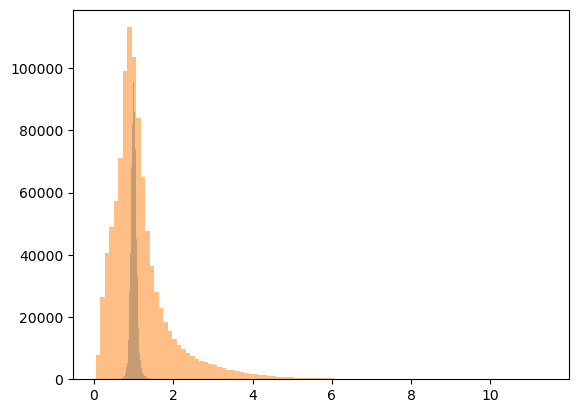

In [60]:
predictions = rho_nn.detach().numpy()
gt = target_density
plt.hist((predictions/gt),bins=100,alpha=0.5)
plt.hist((rho_fit/gt),bins=100,alpha=0.5)

#plt.hist(np.abs(predictions-gt)/np.abs(gt)*100, bins=100)

In [53]:
np.log10(1)

0.0